In [90]:
import os
import pandas as pd
from ggplot import *
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Data Location within CC DS
data_location = os.path.join("..","data","external")


#######################################################
# Helpful Functions I may need

def CAGR(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(by='Date')
    first = df.head(1)
    last = df.tail(1)
    periods = (last.Date-first.Date).astype('timedelta64[m]')
    
    return periods




#######################################################
# Create Lists of Columns for Subsetting Data for Analysis
# Create Mapping of Column Names for Cleanliness
#


compset_oar_list = ['Date',
                   'Region',
                   'Occ-Trans.',
                   'Occ-Grp.',
                   'Occ-Cont.',
                   'Occ-Total',
                   'ADR-Trans.',
                   'ADR-Grp.',
                   'ADR-Cont.',
                   'ADR-Total',
                   'RevPAR-Trans.',
                   'RevPAR-Grp.',
                   'RevPAR-Cont.',
                    'RevPAR-Total']

compset_oar_mapping = {
                   'Occ-Trans.':'OCC_TRANS',
                   'Occ-Grp.':'OCC_GRP',
                   'Occ-Cont.':'OCC_CONT',
                   'Occ-Total':'OCC_TOTAL',
                   'ADR-Trans.':'ADR_TRANS',
                   'ADR-Grp.':'ADR_GRP',
                   'ADR-Cont.':'ADR_CONT',
                   'ADR-Total':'ADR_TOTAL',
                   'RevPAR-Trans.':'RevPAR_TRANS',
                   'RevPAR-Grp.':'RevPAR_GRP',
                   'RevPAR-Cont.':'RevPAR_CONT',
                    'RevPAR-Total':'RevPAR_TOTAL'
                    }


m_cnty_oar_list = ['Year',
                   'Month',
                   'Occ-Trans.',
                   'Occ-Grp.',
                   'Occ-Cont.',
                   'Occ-Total',
                   'ADR-Trans.',
                   'ADR-Grp.',
                   'ADR-Cont.',
                   'ADR-Total',
                   'RevPAR-Trans.',
                   'RevPAR-Grp.',
                   'RevPAR-Cont.',
                    'RevPAR-Total']

m_cnty_oar_mapping = {
                   'Occ-Trans.':'OCC_TRANS',
                   'Occ-Grp.':'OCC_GRP',
                   'Occ-Cont.':'OCC_CONT',
                   'Occ-Total':'OCC_TOTAL',
                   'ADR-Trans.':'ADR_TRANS',
                   'ADR-Grp.':'ADR_GRP',
                   'ADR-Cont.':'ADR_CONT',
                   'ADR-Total':'ADR_TOTAL',
                   'RevPAR-Trans.':'RevPAR_TRANS',
                   'RevPAR-Grp.':'RevPAR_GRP',
                   'RevPAR-Cont.':'RevPAR_CONT',
                    'RevPAR-Total':'RevPAR_TOTAL'
                }



# Read in Monterey County XLS
#
# Documentation for Monterey County XLS goes here...
file_path = os.path.join(data_location, "Monterey-County-City-STR-ALL.xlsx")
m_cnty = pd.read_excel(file_path, sheetname = "County of Monterey 05-16 Seg")
m_cty = pd.read_excel(file_path, sheetname = "City of Monterey 00-16 Agg")

# Read in Compset data
file_path = os.path.join(data_location, "Comp-Set-STR-ALL.xlsx")
compset_hm = pd.read_excel(file_path, sheetname = "Comp-Set OCC-ADR-RevPARv2")

# Read in Budget data
file_path = os.path.join(data_location, "TID_BUDGET.xlsx")
budget = pd.read_excel(file_path, sheetname = "income")


In [91]:
budget.head()

,Year,MCCVB_Income,YOY
0,2005,2879324.0,NaN
1,2006,2647801.0,-0.080409
2,2007,4485942.0,0.694214
3,2008,4841668.0,0.079298
4,2009,3985663.0,-0.176800


In [92]:
###################################################
# Process monterey_county
m_cnty_v1 = m_cnty[m_cnty_oar_list]
m_cnty_v2 = m_cnty_v1.rename(columns=m_cnty_oar_mapping)


m_cnty_v2['Month'] = m_cnty_v2['Month'].apply(str)
m_cnty_v2['Year'] = m_cnty_v2['Year'].apply(str)
m_cnty_v2['Date'] = m_cnty_v2['Year'] + "-" + m_cnty['Month']
m_cnty_v2['Date'] = pd.to_datetime(m_cnty_v2['Date'], format = "%Y-%b")
m_cnty_v2['Month'] = m_cnty_v2['Date'].apply(lambda x: x.month)

m_cnty_v2['Region'] = 'Monterey County, CA'

###################################################
# Process compset data
compset_hm_v1 = compset_hm = compset_hm[compset_oar_list]
compset_hm_v2 = compset_hm_v1.rename(columns=compset_oar_mapping)

#Date & Time Manipulation
compset_hm_v2['Date'] = pd.to_datetime(compset_hm_v2['Date'])
compset_hm_v2['Month'] = compset_hm_v2['Date'].apply(lambda x: x.month)
compset_hm_v2['Year'] = compset_hm_v2['Date'].apply(lambda x: x.year)

#String Manipulation
compset_hm_v2['Region'] = compset_hm_v2['Region'].str.replace('+','')
compset_hm_v2['Region'] = compset_hm_v2['Region'].str.replace('San Jose/Santa Cruz, CA','San Jose-Santa Cruz, CA')

#Leave out Monterey County For Duplicate Data
compset_hm_v2 = compset_hm_v2[compset_hm_v2['Region'] != "Monterey County, CA"]


In [97]:
###############################################
# Combine datasets for Hotel Metrics 
tot_set = compset_hm_v2.append(m_cnty_v2)

# Sort before Calculations (Do I need to do this?)
tot_set = tot_set[tot_set['Date'] > '2011-05-01']
tot_set = tot_set.sort_values(by=['Date'], ascending = True)
tot_set = tot_set.round(2)
tot_set = tot_set.reset_index()

##############################################
# Calculate metrics, in this case, simple growth MOM & YOY
# May consider YTD

#Average Daily Rate  MOM & YOY
tot_set['ADR_GRP_MOM'] =     tot_set.groupby(['Region'])['ADR_GRP'].pct_change(1)
tot_set['ADR_TRANS_MOM'] =   tot_set.groupby(['Region'])['ADR_TRANS'].pct_change(1)
tot_set['ADR_TOTAL_MOM'] =   tot_set.groupby(['Region'])['ADR_TOTAL'].pct_change(1)

tot_set['ADR_GRP_ANN'] =     tot_set.groupby(['Region'])['ADR_GRP'].pct_change(12)
tot_set['ADR_TRANS_ANN'] =   tot_set.groupby(['Region'])['ADR_TRANS'].pct_change(12)
tot_set['ADR_TOTAL_ANN'] =   tot_set.groupby(['Region'])['ADR_TOTAL'].pct_change(12)


#Occupancy MOM & YOY
tot_set['OCC_GRP_MOM'] =     tot_set.groupby(['Region'])['OCC_GRP'].pct_change(1)
tot_set['OCC_TRANS_MOM'] =   tot_set.groupby(['Region'])['OCC_TRANS'].pct_change(1)
tot_set['OCC_TOTAL_MOM'] =   tot_set.groupby(['Region'])['OCC_TOTAL'].pct_change(1)

tot_set['OCC_GRP_ANN'] =     tot_set.groupby(['Region'])['OCC_GRP'].pct_change(12)
tot_set['OCC_TRANS_ANN'] =   tot_set.groupby(['Region'])['OCC_TRANS'].pct_change(12)
tot_set['OCC_TOTAL_ANN'] =   tot_set.groupby(['Region'])['OCC_TOTAL'].pct_change(12)


#RevPar MOM & YOY
tot_set['RevPAR_GRP_MOM'] =     tot_set.groupby(['Region'])['RevPAR_GRP'].pct_change(1)
tot_set['RevPAR_TRANS_MOM'] =   tot_set.groupby(['Region'])['RevPAR_TRANS'].pct_change(1)
tot_set['RevPAR_TOTAL_MOM'] =   tot_set.groupby(['Region'])['RevPAR_TOTAL'].pct_change(1)

tot_set['RevPAR_GRP_ANN'] =     tot_set.groupby(['Region'])['RevPAR_GRP'].pct_change(12)
tot_set['RevPAR_TRANS_ANN'] =   tot_set.groupby(['Region'])['RevPAR_TRANS'].pct_change(12)
tot_set['RevPAR_TOTAL_ANN'] =   tot_set.groupby(['Region'])['RevPAR_TOTAL'].pct_change(12)



#RevPAR Rolling Mean
tot_set['RevPAR_GRP_MOM_ROLL_QTR'] = tot_set.groupby(['Region'])['RevPAR_GRP_MOM'].apply(pd.rolling_mean, 3)









In [94]:
tot_set

,index,ADR_CONT,ADR_GRP,ADR_TOTAL,ADR_TRANS,Date,Month,OCC_CONT,OCC_GRP,OCC_TOTAL,...,OCC_GRP_ANN,OCC_TRANS_ANN,OCC_TOTAL_ANN,RevPAR_GRP_MOM,RevPAR_TRANS_MOM,RevPAR_TOTAL_MOM,RevPAR_GRP_ANN,RevPAR_TRANS_ANN,RevPAR_TOTAL_ANN,RevPAR_GRP_MOM_ROLL_QTR
0,194,0.00,260.57,293.77,308.87,2014-06-01,6,0.00,23.59,75.44,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,203,91.91,151.70,159.43,164.94,2014-06-01,6,2.40,21.50,83.49,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,202,54.31,96.28,107.10,113.61,2014-06-01,6,1.13,13.58,46.42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,201,92.31,183.76,199.28,210.41,2014-06-01,6,1.95,25.13,80.88,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,200,258.18,219.13,302.30,344.76,2014-06-01,6,2.60,26.04,82.33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,113,67.68,150.33,173.99,185.06,2014-06-01,6,0.64,21.81,74.32,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,198,44.89,165.28,148.33,143.22,2014-06-01,6,0.91,22.73,80.65,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,197,136.38,214.01,213.54,219.89,2014-06-01,6,5.14,23.70,89.59,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,196,78.67,187.68,179.97,181.51,2014-06-01,6,2.14,16.17,78.27,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,195,79.21,153.28,147.17,146.90,2014-06-01,6,2.12,25.88,81.73,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


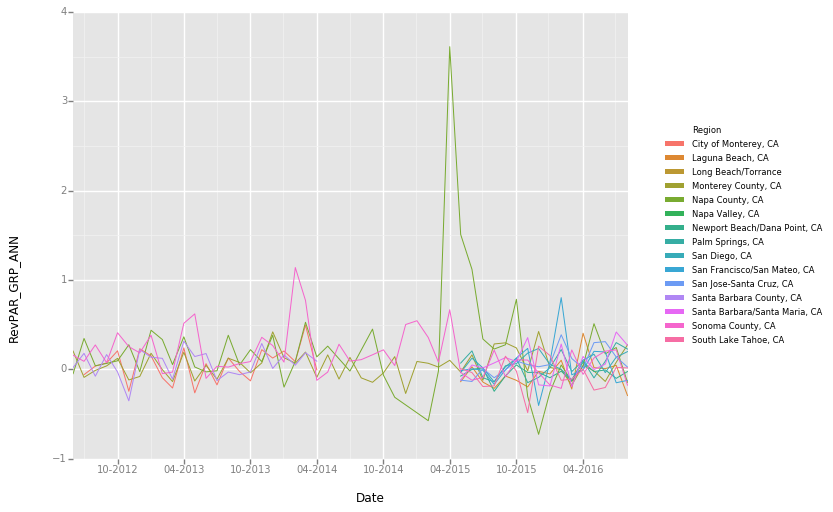

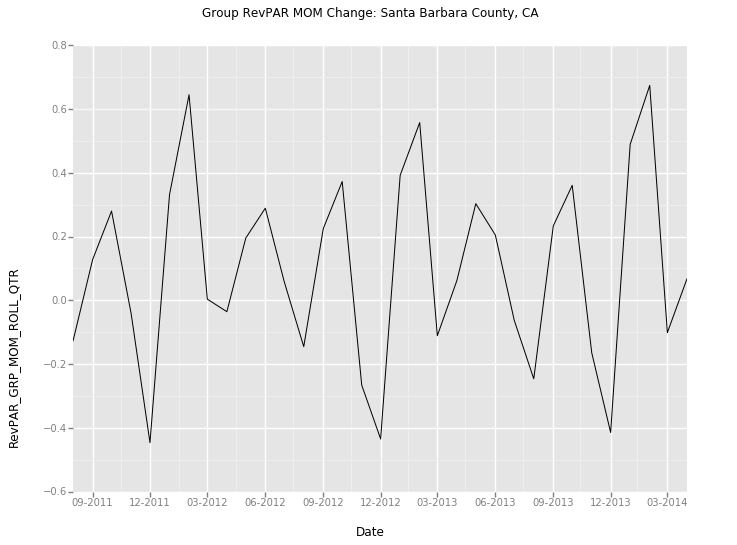

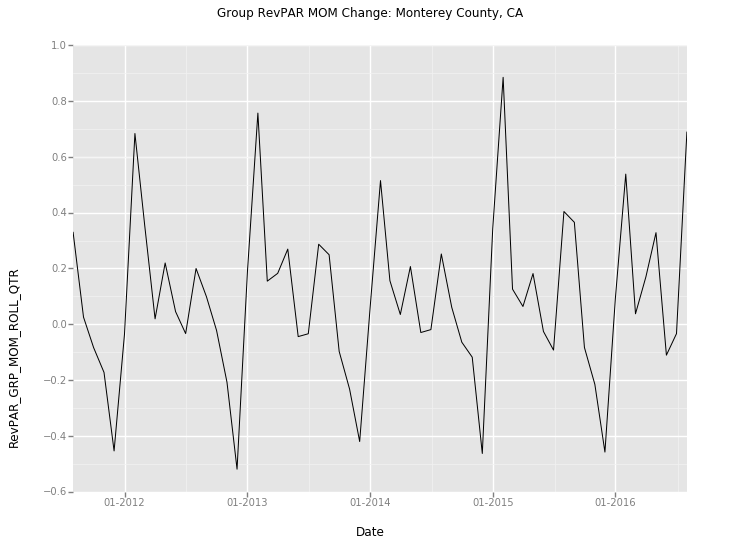

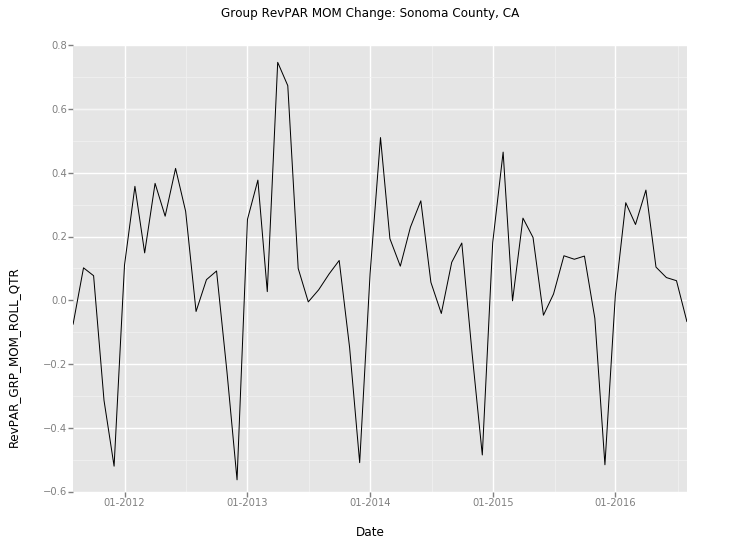

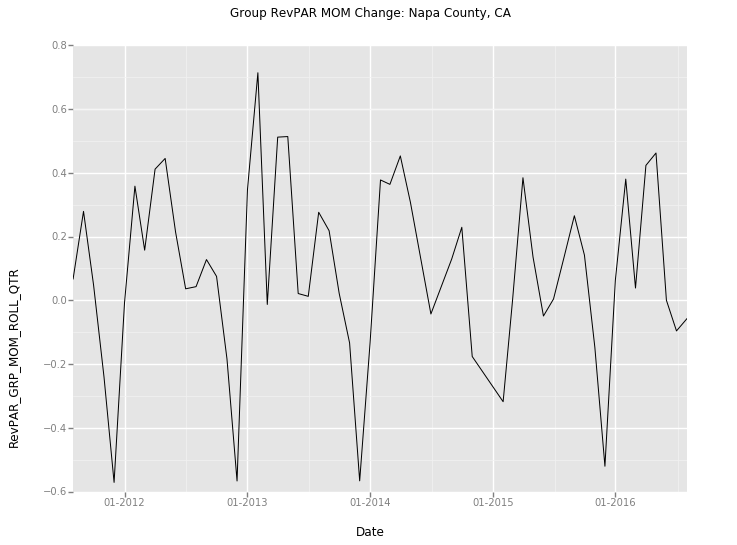

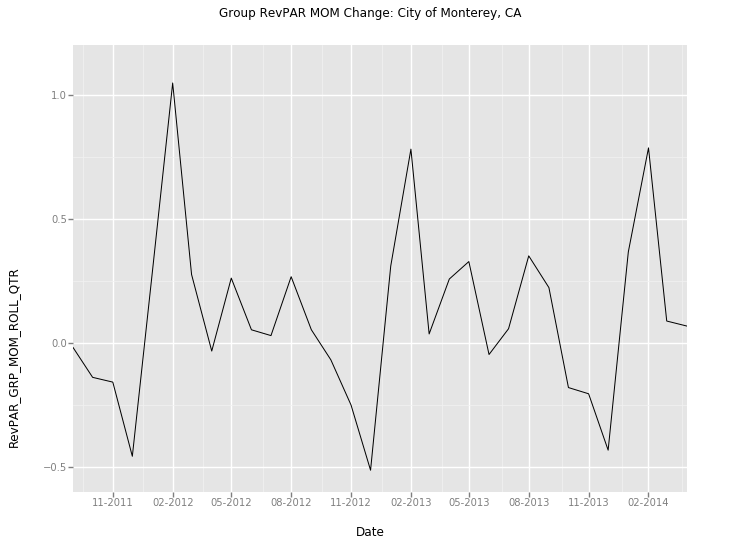

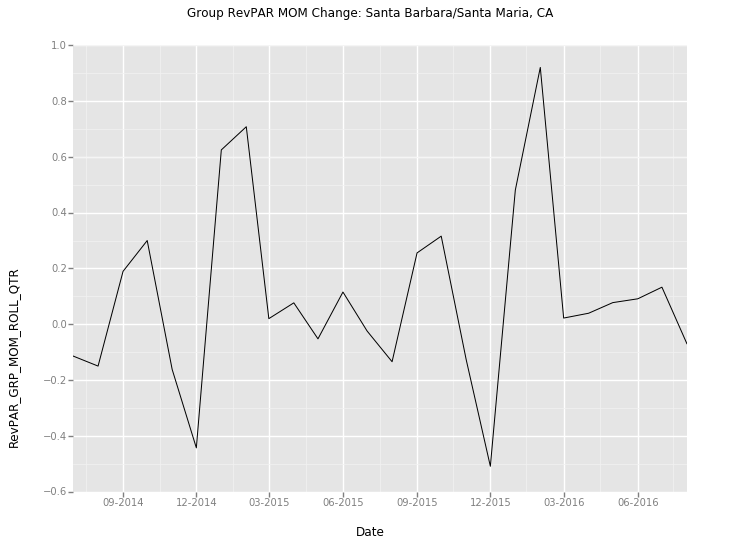

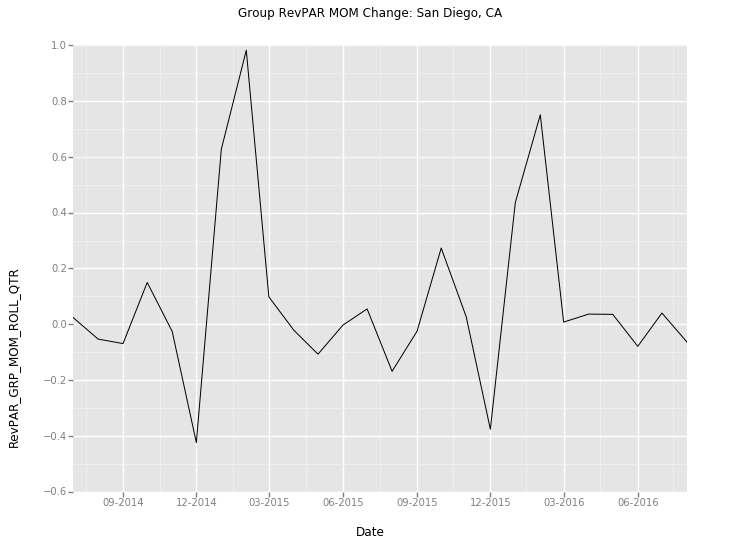

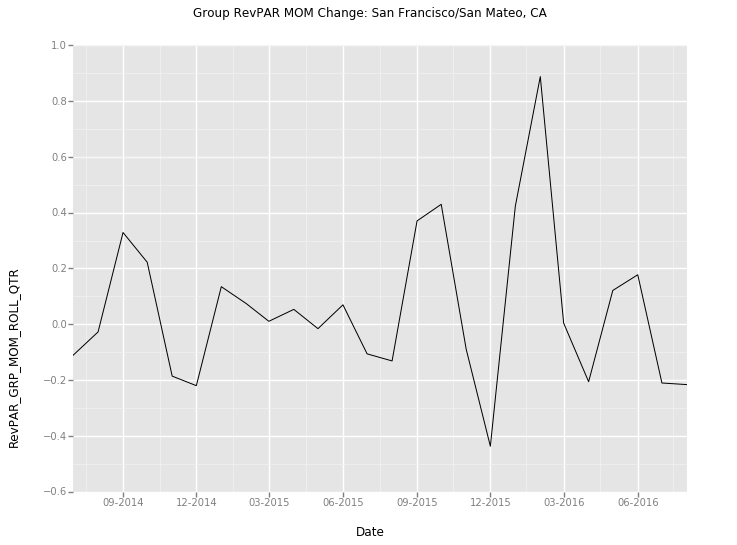

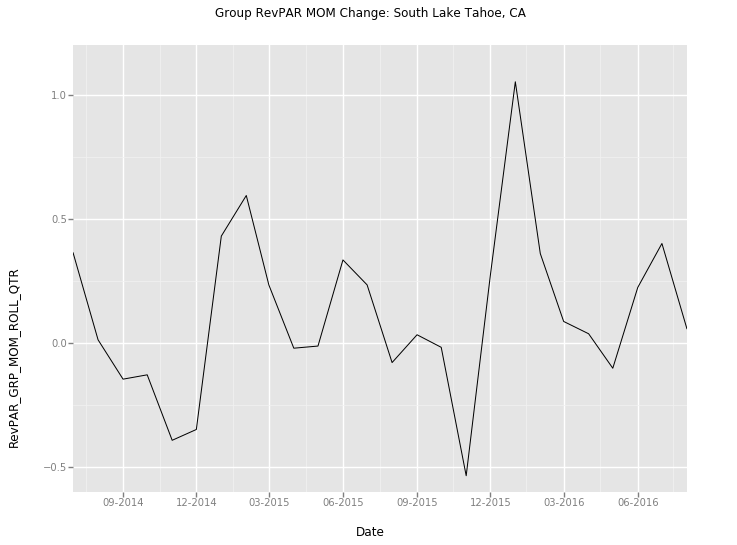

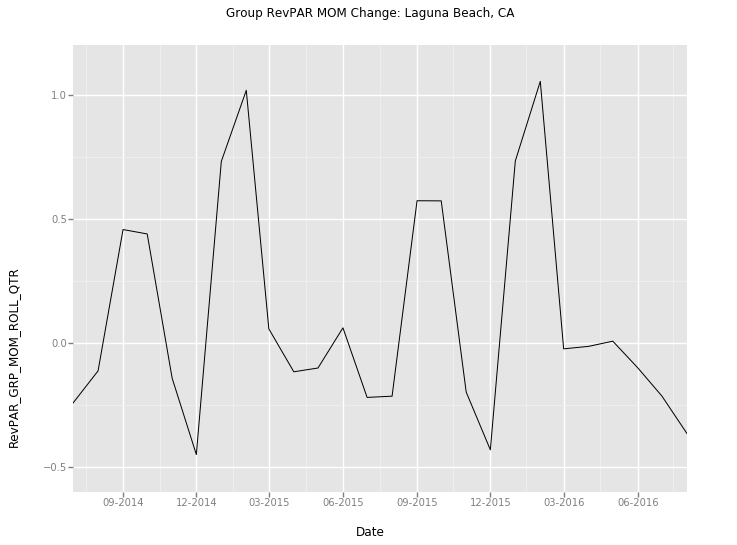

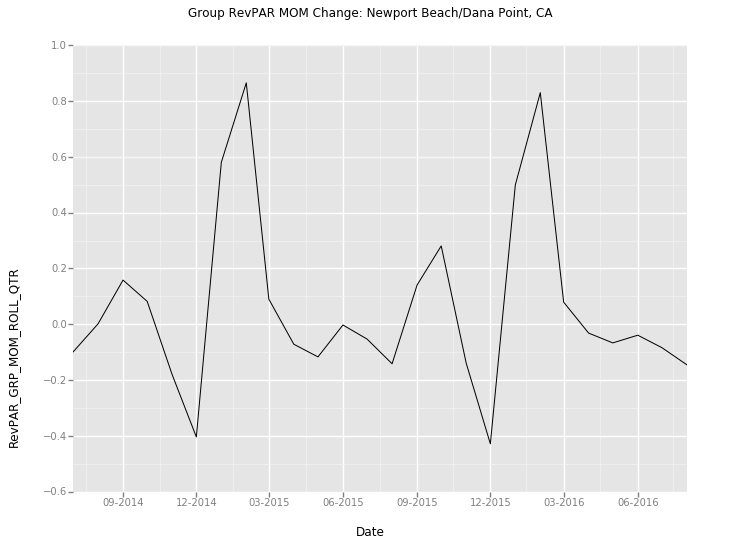

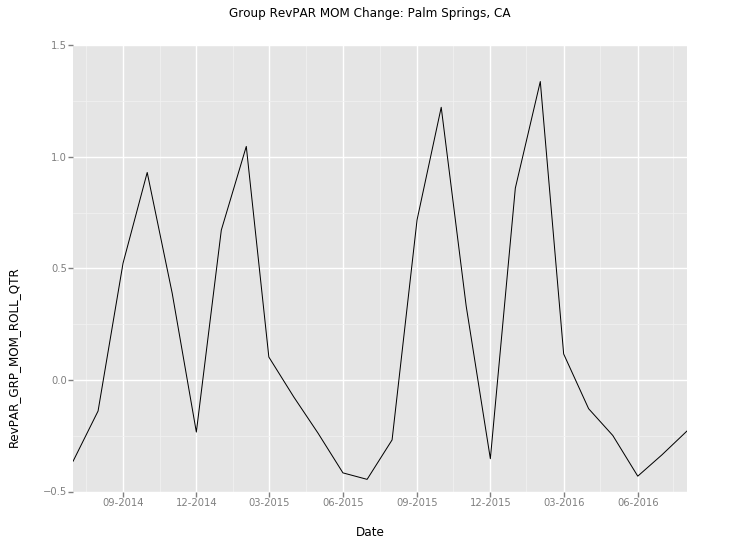

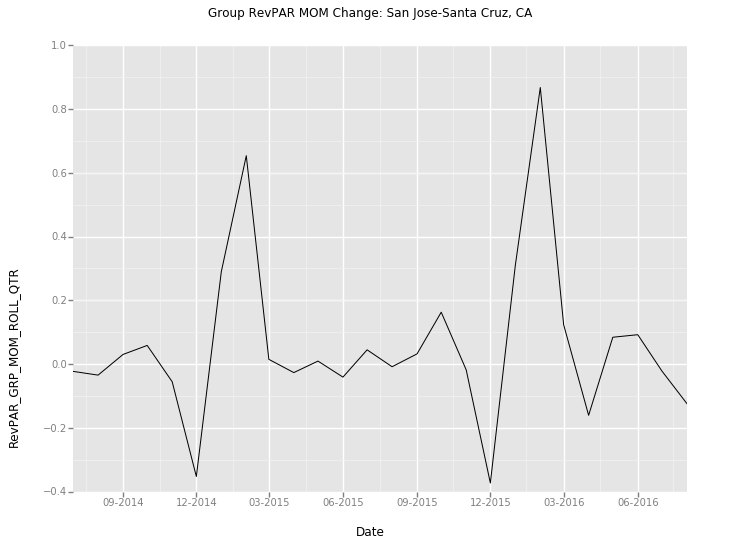

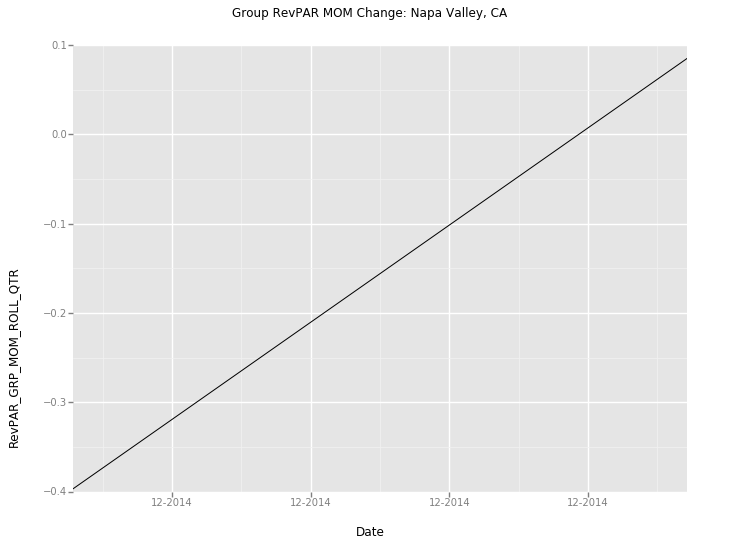

In [102]:
##################################################
# Let's visualize this data for output to Tammy & Rob
# 

#Getting a feel for it
viz_set = tot_set
viz_set['Date'] = pd.to_datetime(viz_set['Date'])
viz_set['Month-Year'] = viz_set['Date'].apply(lambda x: str(x.month) + "-" + str(x.year))
viz_set = viz_set.set_index(viz_set['Date'])

plot = ggplot(aes(x='Date',y='RevPAR_GRP_ANN',color='Region'), viz_set) \
+ geom_line() \
+ geom_hline(yintercept=0,color='black',size=1.7) \
+ scale_x_date(labels='%m-%Y',breaks=date_breaks('week')) \
+ scale_y_continuous(labels='Percent')
plot.show()


#Alright Let's Subset into individual Charts
unique_areas = viz_set['Region'].unique()
plots = {}

for area in unique_areas:
    temp_data = viz_set[viz_set['Region'] == area]
    plot = ggplot(aes(x='Date',y='RevPAR_GRP_MOM_ROLL_QTR'), temp_data) \
    + geom_line() \
    + geom_hline(yintercept=0,color='black',size=1.7) \
    + scale_x_date(labels='%m-%Y',breaks=date_breaks('week')) \
    + scale_y_continuous(labels='Percent')\
    + ggtitle(('Group RevPAR MOM Change: %s') % area)
    
    plots[area] = plot
    try:
        plot.show()
    except:
        "Not Enough Data For Meaningful"